In [1]:
using Distributed
addprocs(8);

In [2]:
@everywhere using PulseInputDDM, MAT, LinearAlgebra
using PyPlot, Colors, Random
import Statistics: mean, median
import Statistics: cor
import PulseInputDDM: cond_mean

In [3]:
ratnames = ["B068","T034","T036","T063","T030", "T035","T011","B053", "T080","T103","E021"];
dt, n, cross = 1e-2, 53, false
data_path = joinpath(abspath(joinpath(pwd(), "..")), "data/by_session")
joint_model_path = joinpath(abspath(joinpath(pwd(), "..")), "models/joint");

## Load data and model parameters

In [4]:
x = Vector(undef, 2);
x_sep = Vector(undef, 2);

In [5]:
region, delay = "FOF", 6
ratnum = 1:5
rat = ratnames[ratnum]
sessions = vcat(map(rat-> filter(x->occursin(rat,x), readdir(data_path)), rat)...);
data_FOF, μ_rnt_FOF, = load_neural_data(joinpath.(data_path, sessions), pcut=0.01, pad=20, delay=delay, dt=dt, 
    filtSD=5, do_RBF=true);
ntrials_FOF = sum(length.(data_FOF));

In [6]:
file = joinpath(joint_model_path, "Fig2-FOF.mat")
f = string.(read(matopen(file), "f"))
ncells = collect(read(matopen(file), "ncells"))
nparams = read(matopen(file), "nparams")
xf = read(matopen(file), "ML_params")
nparamsFOF = nparams;
ncellsFOF = ncells;
borg = vcat(0,cumsum(ncells, dims=1))
nparams = [nparams[i] for i in [borg[i-1]+1:borg[i] for i in 2:length(borg)]]
f = [f[i] for i in [borg[i-1]+1:borg[i] for i in 2:length(borg)]];   
x[1] = xf;
joint_model_FOF = neural_choiceDDM(θneural_choice(xf, f), n, cross);

### Organize model in the neural structure, for easy simulation of spikes trains

In [7]:
neural_model_FOF = neuralDDM(θ=θneural(θz=joint_model_FOF.θ.θz, θy=joint_model_FOF.θ.θy, 
        f=joint_model_FOF.θ.f), 
    n=joint_model_FOF.n, cross=joint_model_FOF.cross);

### Load data and model fits for the independent model

In [8]:
file = joinpath(joint_model_path, "FOF_independent.mat")
f = string.(read(matopen(file), "f"))
ncells = collect(read(matopen(file), "ncells"))
nparams = read(matopen(file), "nparams")
xf = read(matopen(file), "ML_params")
borg = vcat(0,cumsum(ncells, dims=1))
nparams = [nparams[i] for i in [borg[i-1]+1:borg[i] for i in 2:length(borg)]]
f = [f[i] for i in [borg[i-1]+1:borg[i] for i in 2:length(borg)]];  
x_sep[1] = xf;
sep_joint_model_FOF = neural_choiceDDM(θneural_choice(xf, f), n, cross);

In [9]:
data, = load_neural_data(joinpath.(data_path, sessions), pcut=0.01, pad=20, delay=delay, dt=1e-2, filtSD=5,
    do_RBF=true, break_sim_data=true);

In [10]:
data = vcat(data...);

In [11]:
sep_neural_model_FOF = neuralDDM(θ=θneural(θz=sep_joint_model_FOF.θ.θz, 
        θy=map(x-> [x], vcat(sep_joint_model_FOF.θ.θy...)), 
        f=all_Softplus(data)), 
    n=sep_joint_model_FOF.n, cross=sep_joint_model_FOF.cross);

## Organize empirical data based on trial type for computing PSTH, and for removing PSTH predicted component of the autocorrelation function

In [12]:
nconds = 2

2

In [13]:
output = process_spike_data.(μ_rnt_FOF, data_FOF; nconds=nconds);
μ_ct_FOF, σ_ct_FOF = getindex.(output, 1), getindex.(output, 2);

In [14]:
μ_ct_FOF_2 = map(sess-> map(c-> map(n-> μ_ct_FOF[sess][n][c], 1:length(μ_ct_FOF[sess])), 
    1:2), 1:length(μ_ct_FOF));

## Generate synthetic data samples from the fit model

In [15]:
μ_λ_FOF_sep = rand.(Ref(sep_neural_model_FOF.θ.θz), map(x-> [x], vcat(sep_joint_model_FOF.θ.θy...)), 
    data, 1);

In [16]:
ncells_FOF = getfield.(first.(data_FOF), :ncells);
borg = vcat(0,cumsum(ncells_FOF));
μ_λ_FOF_sep_2 = [μ_λ_FOF_sep[i] for i in [borg[i-1]+1:borg[i] for i in 2:length(borg)]];
μ_λ_FOF_sep_2 = map(x-> vcat.(x...), μ_λ_FOF_sep_2);

In [17]:
μ_λ_FOF = rand.(Ref(neural_model_FOF.θ.θz), neural_model_FOF.θ.θy, data_FOF, 2);

In [18]:
μ_c_λ_FOF = cond_mean.(μ_λ_FOF, data_FOF; nconds=nconds);

In [19]:
μ_c_λ_FOF_2 = map(sess-> map(c-> map(n-> μ_c_λ_FOF[sess][n][c], 1:length(μ_c_λ_FOF[sess])), 
    1:2), 1:length(μ_c_λ_FOF));

In [20]:
μ_λ_FOF_sep_2_2 = cond_mean.(μ_λ_FOF_sep_2, data_FOF; nconds=nconds);
μ_λ_FOF_sep_2_2 = map(sess-> map(c-> map(n-> μ_λ_FOF_sep_2_2[sess][n][c], 1:length(μ_λ_FOF_sep_2_2[sess])), 
    1:2), 1:length(μ_λ_FOF_sep_2_2));

## Import functions for computing cross-correlations into notebook

In [21]:
import DePasqualeElife2024: do_xcorrs_real, do_xcorrs_synth

## Compute xcorrs

In [22]:
output = map(i-> do_xcorrs_real(data_FOF, i, μ_ct_FOF_2), 1:length(data_FOF));

mymax = getindex.(output, 1)
xcorr_spikes = getindex.(output, 2);

In [23]:
output = map(i-> do_xcorrs_synth(data_FOF, i, μ_λ_FOF, μ_c_λ_FOF_2), 1:length(data_FOF));

mymax_syn = getindex.(output, 1)
xcorr_spikes_syn = getindex.(output, 2);

In [24]:
output = map(i-> do_xcorrs_synth(data_FOF, i, μ_λ_FOF_sep_2, μ_λ_FOF_sep_2_2), 1:length(data_FOF));

mymax_syn_sep = getindex.(output, 1)
xcorr_spikes_syn_sep = getindex.(output, 2);
cells = getindex.(output, 3);
cells_FOF = cells;

In [25]:
xcorr_spikes_sub = deepcopy(xcorr_spikes);

In [26]:
map(x-> x[159] = NaN, xcorr_spikes_sub[39][map(x-> x[1] == x[2], cells[39])])
map(x-> x[160] = NaN, xcorr_spikes_sub[45][map(x-> x[1] == x[2], cells[45])])

3-element Vector{Float64}:
 NaN
 NaN
 NaN

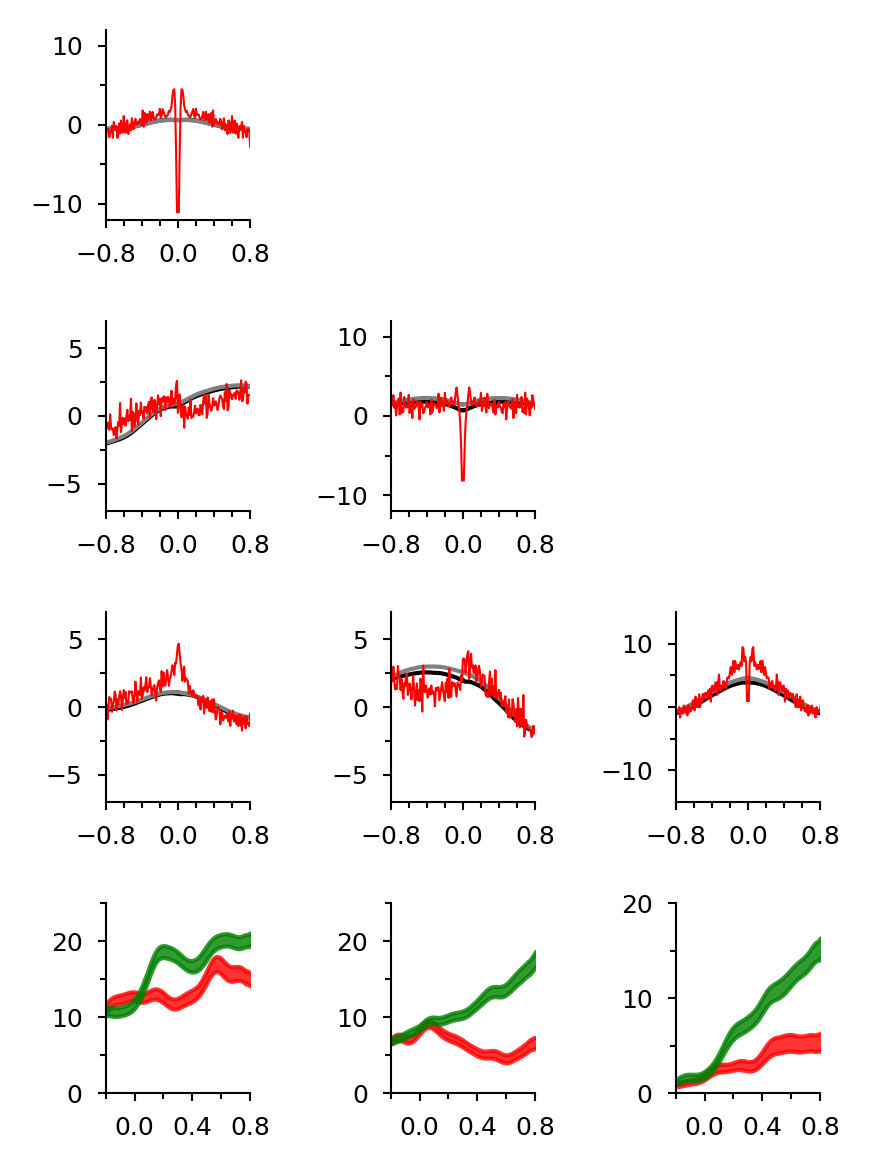

In [29]:
fig, ax = subplots(4, 3, figsize=(3,4), dpi=300, frameon=true)

fs = 6

i = 39

my_colors_FOF= map(x-> "#"*x, hex.(range(colorant"red", stop=colorant"green", length=4)));
my_colors_FOF_2= map(x-> "#"*x, hex.(range(colorant"red", stop=colorant"green", length=nconds)));
rc("xtick", labelsize=fs)
rc("ytick", labelsize=fs)

pltvec = vcat(1,5,9,2:3,6);
 
lw = 1

for j in 1:length(cells[i]) 
     
    ax[reverse(cells[i][j])...].plot((-(mymax_syn[i]-1):(mymax_syn[i]-1))*dt, xcorr_spikes_syn[i][j], color="k", 
        label="shared", linewidth=lw)
    ax[reverse(cells[i][j])...].plot((-(mymax_syn_sep[i]-1):(mymax_syn_sep[i]-1))*dt, xcorr_spikes_syn_sep[i][j], color=[0.5, 0.5, 0.5], 
        linestyle="-", label="independent", linewidth=lw)
    ax[reverse(cells[i][j])...].plot((-(mymax[i]-1):(mymax[i]-1))*dt, xcorr_spikes_sub[i][j], color=my_colors_FOF[1],
        label="data", linewidth=lw/2)
    
    ax[reverse(cells[i][j])...].spines["right"].set_visible(false)
    ax[reverse(cells[i][j])...].spines["top"].set_visible(false)
    ax[reverse(cells[i][j])...].spines["bottom"].set_linewidth(0.5)
    ax[reverse(cells[i][j])...].spines["left"].set_linewidth(0.5)
    ax[reverse(cells[i][j])...].set_xlim(-0.80, 0.80)
    
    if pltvec[j] == 1
        ax[reverse(cells[i][j])...].set_ylim(-12, 12)
        ax[reverse(cells[i][j])...].set_yticks(range(-10, stop=10, length=3))
        ax[reverse(cells[i][j])...].set_yticks(range(-10, stop=10, length=5), minor=true)
    elseif pltvec[j] == 2
        ax[reverse(cells[i][j])...].set_ylim(-7, 7)
        ax[reverse(cells[i][j])...].set_yticks(range(-5, stop=5, length=3))
        ax[reverse(cells[i][j])...].set_yticks(range(-5, stop=5, length=5), minor=true)
    elseif pltvec[j] == 3
        ax[reverse(cells[i][j])...].set_ylim(-7., 7)
        ax[reverse(cells[i][j])...].set_yticks(range(-5, stop=5, length=3))
        ax[reverse(cells[i][j])...].set_yticks(range(-5, stop=5, length=5), minor=true)
    elseif pltvec[j] == 6
        ax[reverse(cells[i][j])...].set_ylim(-7, 7)
        ax[reverse(cells[i][j])...].set_yticks(range(-5, stop=5, length=3))
        ax[reverse(cells[i][j])...].set_yticks(range(-5, stop=5, length=5), minor=true)
    elseif pltvec[j] == 5
        ax[reverse(cells[i][j])...].set_ylim(-12, 12)
        ax[reverse(cells[i][j])...].set_yticks(range(-10, stop=10, length=3))
        ax[reverse(cells[i][j])...].set_yticks(range(-10, stop=10, length=5), minor=true)
    elseif pltvec[j] == 9
        ax[reverse(cells[i][j])...].set_ylim(-15, 15)
        ax[reverse(cells[i][j])...].set_yticks(range(-10, stop=10, length=3))
        ax[reverse(cells[i][j])...].set_yticks(range(-10, stop=10, length=5), minor=true)
    end
    
    ax[reverse(cells[i][j])...].tick_params(width=0.5, length=2)    
    ax[reverse(cells[i][j])...].tick_params(width=0.5, length=2)
    ax[reverse(cells[i][j])...].set_xticks(range(-0.8, stop=0.8, length=3))
    ax[reverse(cells[i][j])...].set_xticks(range(-0.8, stop=0.8, length=9), minor=true)
    ax[reverse(cells[i][j])...].tick_params(which="minor", width=0.5, length=1.5)

end

idxs = [4,8,12]
toplot = collect(1:3)
toplot2 = sum(ncells_FOF[1:i-1]) .+ toplot

for j in 1:length(idxs)  
    
    if idxs[j] == 4 
        ax[idxs[j]].set_ylim(0, 25)
        ax[idxs[j]].set_yticks(sort(vcat(range(0., stop=20., length=3))))
        ax[idxs[j]].set_yticks(range(0., stop=25, length=6), minor=true)
        
    elseif idxs[j] == 8
        ax[idxs[j]].set_ylim(0, 25)
        ax[idxs[j]].set_yticks(sort(vcat(range(0., stop=20., length=3))))
        ax[idxs[j]].set_yticks(range(0., stop=25, length=6), minor=true)
        
    elseif idxs[j] == 12

        ax[idxs[j]].set_ylim(0, 20)
        ax[idxs[j]].set_yticks(sort(vcat(range(0., stop=20., length=3))))
        ax[idxs[j]].set_yticks(range(0., stop=20, length=5), minor=true)

    end

    for k = 1:nconds   

        ax[idxs[j]].fill_between((1:length(μ_ct_FOF[i][toplot[j]][k]))*dt .- 0.2,
            μ_ct_FOF[i][toplot[j]][k] + σ_ct_FOF[i][toplot[j]][k],
            μ_ct_FOF[i][toplot[j]][k] - σ_ct_FOF[i][toplot[j]][k],
            alpha=0.8, color=my_colors_FOF_2[k]) 

    end   
        
    ax[idxs[j]].set_xlim(-0.2, 0.8)    
    ax[idxs[j]].spines["right"].set_visible(false)
    ax[idxs[j]].spines["top"].set_visible(false)
    ax[idxs[j]].spines["bottom"].set_linewidth(0.5)
    ax[idxs[j]].spines["left"].set_linewidth(0.5)
    
    ax[idxs[j]].tick_params(width=0.5, length=2)
    ax[idxs[j]].set_xticks(range(-0.0, stop=0.8, length=3))
    ax[idxs[j]].set_xticks(range(-0.2, stop=0.8, length=6), minor=true)
    ax[idxs[j]].tick_params(which="minor", width=0.5, length=1.5)  

end

[ax[i].axis("off") for i in [5,9,10]]

tight_layout() 
display(gcf())
close(gcf())
#PyPlot.savefig(joinpath(abspath(joinpath(pwd(), "..")), "figs/")*"Fig4C.pdf")

#### Pearson correlation between synthetic and empirial cross-correlation functions

In [30]:
flat_xcorr_spikes = vec.(vcat(xcorr_spikes...));
flat_xcorr_spikes_syn = vec.(vcat(xcorr_spikes_syn...));
flat_xcorr_spikes_syn_sep = vec.(vcat(xcorr_spikes_syn_sep...));

cut_xcorr_spikes = map(x-> x[Int((length(x) - 1)/2) - 80 + 1: Int((length(x) - 1)/2)+80+1], flat_xcorr_spikes);
cut_xcorr_spikes_syn = map(x-> x[Int((length(x) - 1)/2) - 80 + 1: Int((length(x) - 1)/2)+80+1], flat_xcorr_spikes_syn);
cut_xcorr_spikes_syn_sep = map(x-> x[Int((length(x) - 1)/2) - 80 + 1: Int((length(x) - 1)/2)+80+1], flat_xcorr_spikes_syn_sep);

In [31]:
borg = vcat(0,cumsum(length.(cells_FOF), dims=1))
cut_xcorr_spikes_2 = [cut_xcorr_spikes[i] for i in [borg[i-1]+1:borg[i] for i in 2:length(borg)]];   
cut_xcorr_spikes_syn_2 = [cut_xcorr_spikes_syn[i] for i in [borg[i-1]+1:borg[i] for i in 2:length(borg)]];   
cut_xcorr_spikes_syn_sep_2 = [cut_xcorr_spikes_syn_sep[i] for i in [borg[i-1]+1:borg[i] for i in 2:length(borg)]];   

In [32]:
pearFOF_cross = map((x,y,z)-> map((x,y,z)-> (x[1] .!== x[2] ? cor(y,z) : NaN), x, y, z), cells_FOF, 
    cut_xcorr_spikes_2, cut_xcorr_spikes_syn_2);

In [33]:
pearFOF_cross_sep = map((x,y,z)-> map((x,y,z)-> (x[1] .!== x[2] ? cor(y,z) : NaN), x, y, z), cells_FOF, 
    cut_xcorr_spikes_2, cut_xcorr_spikes_syn_sep_2);

In [34]:
mean_pearFOF_cross = mean(abs.(filter(!isnan, vcat(pearFOF_cross...))))

0.5909348256718756

In [35]:
mean_pearFOF_sep_cross = mean(abs.(filter(!isnan, vcat(pearFOF_cross_sep...))))

0.5828025185280744

## Run the same analysis for the ADS data

In [36]:
region, delay = "ADS", 6
ratnum = 9:11
rat = ratnames[ratnum]

sessions = vcat(map(rat-> filter(x->occursin(rat,x), readdir(data_path)), rat)...);

data_STR, μ_rnt_STR, = load_neural_data(joinpath.(data_path, sessions), pcut=0.01, pad=20, delay=delay, dt=dt, 
    filtSD=5, do_RBF=true);
ntrials_STR = sum(length.(data_STR));

In [37]:
file = joinpath(joint_model_path, "Fig2-ADS.mat")
f = string.(read(matopen(file), "f"))
ncells = collect(read(matopen(file), "ncells"))
nparams = read(matopen(file), "nparams")
xf = read(matopen(file), "ML_params")
borg = vcat(0,cumsum(ncells, dims=1))
nparams = [nparams[i] for i in [borg[i-1]+1:borg[i] for i in 2:length(borg)]]
f = [f[i] for i in [borg[i-1]+1:borg[i] for i in 2:length(borg)]];   
x[2] = xf;
joint_model_STR = neural_choiceDDM(θneural_choice(xf, f), n, cross)

neural_choiceDDM{θneural_choice{θz{Float64}, Float64, Vector{Vector{Softplus{Float64}}}}}
  θ: θneural_choice{θz{Float64}, Float64, Vector{Vector{Softplus{Float64}}}}
  n: Int64 53
  cross: Bool false


In [38]:
neural_model_STR = neuralDDM(θ=θneural(θz=joint_model_STR.θ.θz, θy=joint_model_STR.θ.θy, 
        f=joint_model_STR.θ.f), 
    n=joint_model_STR.n, cross=joint_model_STR.cross);

In [39]:
file = joinpath(joint_model_path, "ADS_independent.mat")
f = string.(read(matopen(file), "f"))
ncells = collect(read(matopen(file), "ncells"))
nparams = read(matopen(file), "nparams")
xf = read(matopen(file), "ML_params")
borg = vcat(0,cumsum(ncells, dims=1))
nparams = [nparams[i] for i in [borg[i-1]+1:borg[i] for i in 2:length(borg)]]
f = [f[i] for i in [borg[i-1]+1:borg[i] for i in 2:length(borg)]];  
x_sep[2] = xf;
sep_joint_model_STR = neural_choiceDDM(θneural_choice(xf, f), n, cross)

neural_choiceDDM{θneural_choice{θz{Float64}, Float64, Vector{Vector{Softplus{Float64}}}}}
  θ: θneural_choice{θz{Float64}, Float64, Vector{Vector{Softplus{Float64}}}}
  n: Int64 53
  cross: Bool false


In [40]:
data, = load_neural_data(joinpath.(data_path, sessions), pcut=0.01, pad=20, delay=delay, dt=1e-2, filtSD=5,
    do_RBF=true, break_sim_data=true);
data = vcat(data...);

In [41]:
sep_neural_model_STR = neuralDDM(θ=θneural(θz=sep_joint_model_STR.θ.θz, 
        θy=map(x-> [x], vcat(sep_joint_model_STR.θ.θy...)), 
        f=all_Softplus(data)), 
    n=sep_joint_model_STR.n, cross=sep_joint_model_STR.cross);

In [42]:
output = process_spike_data.(μ_rnt_STR, data_STR; nconds=nconds);
μ_ct_STR, σ_ct_STR = getindex.(output, 1), getindex.(output, 2);

In [43]:
μ_ct_STR_2 = map(sess-> map(c-> map(n-> μ_ct_STR[sess][n][c], 1:length(μ_ct_STR[sess])), 
    1:2), 1:length(μ_ct_STR));

In [44]:
μ_λ_STR_sep = rand.(Ref(sep_neural_model_STR.θ.θz), map(x-> [x], vcat(sep_joint_model_STR.θ.θy...)), 
    data, 1);

ncells_STR = getfield.(first.(data_STR), :ncells);
borg = vcat(0,cumsum(ncells_STR))
μ_λ_STR_sep_2 = [μ_λ_STR_sep[i] for i in [borg[i-1]+1:borg[i] for i in 2:length(borg)]];
μ_λ_STR_sep_2 = map(x-> vcat.(x...), μ_λ_STR_sep_2);

In [45]:
μ_λ_STR = rand.(Ref(neural_model_STR.θ.θz), neural_model_STR.θ.θy, data_STR, 2);

In [46]:
μ_c_λ_STR = cond_mean.(μ_λ_STR, data_STR; nconds=nconds);

μ_c_λ_STR_2 = map(sess-> map(c-> map(n-> μ_c_λ_STR[sess][n][c], 1:length(μ_c_λ_STR[sess])), 
    1:2), 1:length(μ_c_λ_STR));

μ_λ_STR_sep_2_2 = cond_mean.(μ_λ_STR_sep_2, data_STR; nconds=nconds);
μ_λ_STR_sep_2_2 = map(sess-> map(c-> map(n-> μ_λ_STR_sep_2_2[sess][n][c], 1:length(μ_λ_STR_sep_2_2[sess])), 
    1:2), 1:length(μ_λ_STR_sep_2_2));

In [47]:
output = map(i-> do_xcorrs_real(data_STR, i, μ_ct_STR_2), 1:length(data_STR));

mymax = getindex.(output, 1)
xcorr_spikes = getindex.(output, 2);

In [48]:
output = map(i-> do_xcorrs_synth(data_STR, i, μ_λ_STR, μ_c_λ_STR_2), 1:length(data_STR));

mymax_syn = getindex.(output, 1)
xcorr_spikes_syn = getindex.(output, 2);

In [49]:
output = map(i-> do_xcorrs_synth(data_STR, i, μ_λ_STR_sep_2, μ_λ_STR_sep_2_2), 1:length(data_STR));

mymax_syn_sep = getindex.(output, 1)
xcorr_spikes_syn_sep = getindex.(output, 2);
cells = getindex.(output, 3);
cells_STR = cells;

In [50]:
cells_sub = cells[13][[1,3,5,7,9,14]]
cells_sub[2] = [2,2]
cells_sub[3] = [3,3]
cells_sub[4] = [1,2]
cells_sub[5] = [1,3]
cells_sub[6] = [2,3];

In [51]:
xcorr_spikes_sub = deepcopy(xcorr_spikes);

In [52]:
map(x-> x[139] = NaN, xcorr_spikes_sub[13][map(x-> x[1] == x[2], cells[13])])

5-element Vector{Float64}:
 NaN
 NaN
 NaN
 NaN
 NaN

In [53]:
xcorr_spikes_syn_sub = xcorr_spikes_syn[13][[1,3,5,7,9,14]];
xcorr_spikes_syn_sep_sub = xcorr_spikes_syn_sep[13][[1,3,5,7,9,14]];
xcorr_spikes_sub = xcorr_spikes_sub[13][[1,3,5,7,9,14]];

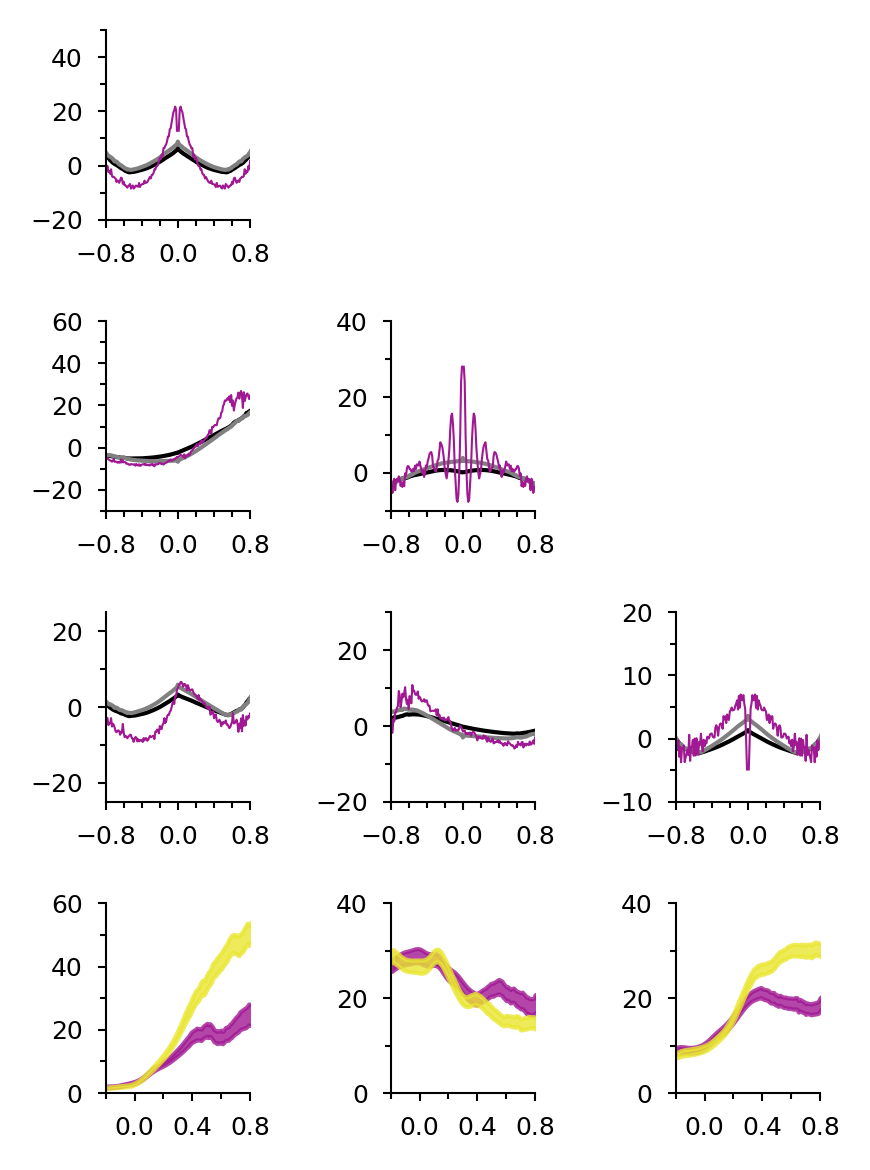

In [54]:
fig, ax = subplots(4, 3, figsize=(3,4), dpi=300, frameon=true)

fs = 6

my_colors_STR= map(x-> "#"*x, hex.(range(colorant"#A01892", stop=colorant"#E9E62F", length=4)));
my_colors_STR_2= map(x-> "#"*x, hex.(range(colorant"#A01892", stop=colorant"#E9E62F", length=nconds)));
my_colors_FOF= map(x-> "#"*x, hex.(range(colorant"red", stop=colorant"green", length=nconds)));

rc("xtick", labelsize=fs)
rc("ytick", labelsize=fs)

pltvec = vcat(1,5,9,2:3,6);

i = 13   
lw = 1

for j in 1:length(cells_sub)  

    ax[reverse(cells_sub[j])...].plot((-(mymax_syn[i]-1):(mymax_syn[i]-1))*dt, xcorr_spikes_syn_sub[j], color="k", 
        label="shared", linewidth=lw)
    ax[reverse(cells_sub[j])...].plot((-(mymax_syn_sep[i]-1):(mymax_syn_sep[i]-1))*dt, xcorr_spikes_syn_sep_sub[j], color=[0.5, 0.5, 0.5], 
        linestyle="-", label="independent", linewidth=lw)
    ax[reverse(cells_sub[j])...].plot((-(mymax[i]-1):(mymax[i]-1))*dt, xcorr_spikes_sub[j], color=my_colors_STR[1],
        label="data", linewidth=lw/2)
    
    ax[reverse(cells_sub[j])...].spines["right"].set_visible(false)
    ax[reverse(cells_sub[j])...].spines["top"].set_visible(false)
    ax[reverse(cells_sub[j])...].spines["bottom"].set_linewidth(0.5)
    ax[reverse(cells_sub[j])...].spines["left"].set_linewidth(0.5)
    ax[reverse(cells_sub[j])...].set_xlim(-0.80, 0.80)
    ax[reverse(cells_sub[j])...].set_xticks([-0.80, 0, 0.80])
    
    if pltvec[j] == 1
        ax[reverse(cells_sub[j])...].set_ylim(-20, 50)
        ax[reverse(cells_sub[j])...].set_yticks(range(-20, stop=40, length=4))
        ax[reverse(cells_sub[j])...].set_yticks(range(-20, stop=50, length=8), minor=true)
    elseif pltvec[j] == 2
        ax[reverse(cells_sub[j])...].set_ylim(-30, 60)
        ax[reverse(cells_sub[j])...].set_yticks(range(-20, stop=60, length=5))
        ax[reverse(cells_sub[j])...].set_yticks(range(-30, stop=60, length=10), minor=true)
    elseif pltvec[j] == 3
        ax[reverse(cells_sub[j])...].set_ylim(-25, 25)
        ax[reverse(cells_sub[j])...].set_yticks(range(-20, stop=20, length=3))
        ax[reverse(cells_sub[j])...].set_yticks(range(-20, stop=20, length=5), minor=true)
    elseif pltvec[j] == 5
        ax[reverse(cells_sub[j])...].set_ylim(-10, 40)
        ax[reverse(cells_sub[j])...].set_yticks(range(0, stop=40, length=3))
        ax[reverse(cells_sub[j])...].set_yticks(range(-10, stop=40, length=6), minor=true)
    elseif pltvec[j] == 6
        ax[reverse(cells_sub[j])...].set_ylim(-20, 30)   
        ax[reverse(cells_sub[j])...].set_yticks(range(-20, stop=20, length=3))
        ax[reverse(cells_sub[j])...].set_yticks(range(-20, stop=30, length=6), minor=true)
    elseif pltvec[j] == 9
        ax[reverse(cells_sub[j])...].set_ylim(-10, 20)
        ax[reverse(cells_sub[j])...].set_yticks(range(-10, stop=20, length=4))
        ax[reverse(cells_sub[j])...].set_yticks(range(-10, stop=20, length=7), minor=true)
    end
        
    ax[reverse(cells_sub[j])...].tick_params(width=0.5, length=2)  
    ax[reverse(cells_sub[j])...].tick_params(width=0.5, length=2)
    ax[reverse(cells_sub[j])...].set_xticks(range(-0.8, stop=0.8, length=3))
    ax[reverse(cells_sub[j])...].set_xticks(range(-0.8, stop=0.8, length=9), minor=true)
    ax[reverse(cells_sub[j])...].tick_params(which="minor", width=0.5, length=1.5)

end

idxs = [4,8,12]
toplot = [1,3,5]
toplot2 = sum(ncells_STR[1:i-1]) .+ toplot

for j in 1:length(idxs)  
    
    if idxs[j] == 4  
        ax[idxs[j]].set_ylim(0, 60)
        ax[idxs[j]].set_yticks(range(0., stop=60, length=7), minor=true)
        ax[idxs[j]].set_yticks(sort(vcat(range(0., stop=60., length=4))))
    elseif idxs[j] == 8  
        ax[idxs[j]].set_ylim(0, 40)
        ax[idxs[j]].set_yticks(range(0., stop=40, length=5), minor=true)
        ax[idxs[j]].set_yticks(sort(vcat(range(0., stop=40., length=3))))
    elseif idxs[j] == 12
        ax[idxs[j]].set_ylim(0, 40)
        ax[idxs[j]].set_yticks(range(0., stop=40, length=5), minor=true)
        ax[idxs[j]].set_yticks(sort(vcat(range(0., stop=40., length=3))))
    end
    
    for k = 1:nconds   

        ax[idxs[j]].fill_between((1:length(μ_ct_STR[i][toplot[j]][k]))*dt .- 0.2,
            μ_ct_STR[i][toplot[j]][k] + σ_ct_STR[i][toplot[j]][k],
            μ_ct_STR[i][toplot[j]][k] - σ_ct_STR[i][toplot[j]][k],
            alpha=0.8, color=my_colors_STR_2[k]) 
        
    end   
     
    ax[idxs[j]].set_xlim(-0.2, 0.8)
    ax[idxs[j]].spines["right"].set_visible(false)
    ax[idxs[j]].spines["top"].set_visible(false)
    ax[idxs[j]].spines["bottom"].set_linewidth(0.5)
    ax[idxs[j]].spines["left"].set_linewidth(0.5)
    
    ax[idxs[j]].tick_params(width=0.5, length=2)
    ax[idxs[j]].set_xticks(range(-0.0, stop=0.8, length=3))
    ax[idxs[j]].set_xticks(range(-0.2, stop=0.8, length=6), minor=true)
    ax[idxs[j]].tick_params(which="minor", width=0.5, length=1.5) 
  

end

[ax[i].axis("off") for i in [5,9,10]]

tight_layout() 
display(gcf())
close(gcf())
#PyPlot.savefig(joinpath(abspath(joinpath(pwd(), "..")), "figs/")*"Fig4D.pdf")

In [55]:
flat_xcorr_spikes = vec.(vcat(xcorr_spikes...));
flat_xcorr_spikes_syn = vec.(vcat(xcorr_spikes_syn...));
flat_xcorr_spikes_syn_sep = vec.(vcat(xcorr_spikes_syn_sep...));
cut_xcorr_spikes = map(x-> x[Int((length(x) - 1)/2) - 80 + 1: Int((length(x) - 1)/2)+80+1], flat_xcorr_spikes);
cut_xcorr_spikes_syn = map(x-> x[Int((length(x) - 1)/2) - 80 + 1: Int((length(x) - 1)/2)+80+1], flat_xcorr_spikes_syn);
cut_xcorr_spikes_syn_sep = map(x-> x[Int((length(x) - 1)/2) - 80 + 1: Int((length(x) - 1)/2)+80+1], flat_xcorr_spikes_syn_sep);

In [56]:
borg = vcat(0,cumsum(length.(cells_STR), dims=1))
cut_xcorr_spikes_2 = [cut_xcorr_spikes[i] for i in [borg[i-1]+1:borg[i] for i in 2:length(borg)]];   
cut_xcorr_spikes_syn_2 = [cut_xcorr_spikes_syn[i] for i in [borg[i-1]+1:borg[i] for i in 2:length(borg)]];   
cut_xcorr_spikes_syn_sep_2 = [cut_xcorr_spikes_syn_sep[i] for i in [borg[i-1]+1:borg[i] for i in 2:length(borg)]];   

In [57]:
pearSTR_cross = map((x,y,z)-> map((x,y,z)-> (x[1] .!== x[2] ? cor(y,z) : NaN), x, y, z), cells_STR, 
    cut_xcorr_spikes_2, cut_xcorr_spikes_syn_2);

pearSTR_cross_sep = map((x,y,z)-> map((x,y,z)-> (x[1] .!== x[2] ? cor(y,z) : NaN), x, y, z), cells_STR, 
    cut_xcorr_spikes_2, cut_xcorr_spikes_syn_sep_2);

In [58]:
mean_pearSTR_cross = mean(abs.(filter(!isnan, vcat(pearSTR_cross...))))

0.63591662550059

In [59]:
mean_pearSTR_sep_cross = mean(abs.(filter(!isnan, vcat(pearSTR_cross_sep...))))

0.6011824571332381